# TinyPerson Dataset

Follow this notebook to prepare TinyPerson dataset.

**Description:**
- TinyPerson source dataset is containing 1498 labeled, static RGB aerial images (717 for training and 781 for testing) captured using UAVs in different places, environments and heights.

**Annotations:**
- annotations are stored in single .json file for each subset
- segmentation,bbox[bbox_left, bbox_top, bbox_width, bbox_height], category_id, area, iscrowd, image_id, id
- bounding bot in xywh format

**Source objects categories:**
- sea_person (1), earth_person (2) - distinction between people detected in water and on land

**Table of content:**

0. Init - imports and data download
1. Data transformation
2. Clenup
3. Dataset visualization

## 0. Init - imports and data download

Dataset can be downloaded from one of three sources shown in [Tiny Person github](https://github.com/ucas-vg/PointTinyBenchmark/tree/TinyBenchmark). Given the needs of this project, only part of files in the dataset will be used. Files that will be used during data processing are:
- trainset annotations stored in JSON file `tiny_set/annotations/tiny_set_train.json`
- testset annotations stored in JSON file`tiny_set/annotations/tiny_set_test.json`
- traiset stored in tar.gz archive `tiny_set/train.tar.gz`
- testset stored in tar.gz archive `tiny_set/test.tar.gz`

after unpacking the archives they should have given structure:
 - for trainset
```
train
├───annotations
├───labeled_images
├───annotations
└───labeled_images
```
- for testset
```
test
├───annotations
├───labeled_images
├───annotations
└───labeled_images
```

In further processing we will be using only content of `test/labeled_images` and `train/labeled_images`. To process the files it is recommended to move folders with photos and .json file with annotations to project directory to create files structure shown below.

```
data
└───source
    └───TinyPerson
        ├───test
        │   ├───tiny_set_test.json
        │   └───labeled_images
        └───train
            ├───tiny_set_train.json
            └───labeled_images
```

In [58]:
# Uncomment below two lines to reload imported packages (in case of modifying them)
# %load_ext autoreload
# %autoreload 2

import os
import random
from random import sample


from prj_utils.consts import ROOT_DIR
from data_processing.tiny_person_dataset_processing import from_tiny_people_json_to_xywhn_yolo_format
from data_processing.tiny_person_dataset_processing import copy_tiny_people_images_to_given_dir
from data_processing.tiny_person_dataset_processing import split_test_into_validation_set
from data_processing.image_processing import plot_xywhn_annotated_image_from_file
from data_processing.tiny_person_dataset_processing import clean_up_bboxes_in_blurred_areas
from data_processing.image_processing import get_number_of_objects_stats


TRAIN_DIR = f'{ROOT_DIR}/data/source/TinyPerson/train'
TEST_DIR = f'{ROOT_DIR}/data/source/TinyPerson/test'
TRAIN_ANNO_DIR = f'{TRAIN_DIR}/tiny_set_train.json'
TEST_ANNO_DIR = f'{TEST_DIR}/tiny_set_test.json'

TRAIN_PROCESSED_DIR = f'{ROOT_DIR}/data/processed/TinyPerson/train'
TEST_PROCESSED_DIR = f'{ROOT_DIR}/data/processed/TinyPerson/test'
VALIDATE_PROCESSED_DIR = f'{ROOT_DIR}/data/processed/TinyPerson/validate'

## 1. Data transformation
- Convert data to YOLO format
- Image transformations
- Separation of validation set

### 1.1 Convert annotations to YOLO format

Yolo format:
- One *.txt file per image (if no objects in image, no *.txt file is required).
- One row per object.
- Each row is `class x_center y_center scaled_width scaled_height` format, separated by space.
- Box coordinates must be in normalized from 0 to 1. If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
- Bounding box in annotation in xywhn format
- Class numbers are zero-indexed (start from 0).

More about yolo format data [here](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data#11-create-datasetyaml).

In [59]:
from_tiny_people_json_to_xywhn_yolo_format(TEST_ANNO_DIR,f'{TEST_DIR}/labeled_images',f'{TEST_PROCESSED_DIR}/labels')
from_tiny_people_json_to_xywhn_yolo_format(TRAIN_ANNO_DIR,f'{TRAIN_DIR}/labeled_images',f'{TRAIN_PROCESSED_DIR}/labels')

### 1.2 Image transformations
- Copy images only with annotations from source directory to processed.

After this step processed data directory should look like this:

```
data
└───processed
    └───TinyPerson
        ├───test
        │   ├───images
        │   └───labels
        └───train
            ├───images
            └───labels
```

In [60]:
copy_tiny_people_images_to_given_dir(f'{TEST_DIR}/labeled_images',f'{TEST_PROCESSED_DIR}/images')
copy_tiny_people_images_to_given_dir(f'{TRAIN_DIR}/labeled_images',f'{TRAIN_PROCESSED_DIR}/images')

### 1.3 Separation of validation test
- Split test subset into test subset and validation subset

After this step processed data directory should look like this:

```
data
└───processed
    └───TinyPerson
        ├───test
        │   ├───images
        │   └───labels
        ├───train
        │   ├───images
        │   └───labels
        └───validate
            ├───images
            └───labels
```

In [61]:
split_test_into_validation_set(TEST_PROCESSED_DIR,VALIDATE_PROCESSED_DIR)

### 2 Cleanup
- Delete false annotations

### 2.1 Delete false annotations
Delete annotations pertaining to blurred rectangular areas present in some of the photos

In [62]:
clean_up_bboxes_in_blurred_areas(f'{TRAIN_PROCESSED_DIR}/labels/',f'{VALIDATE_PROCESSED_DIR}/labels/',f'{TEST_DIR}/labels/')

## 3. Dataset visualization
- Dataset stats
- Data annotation visualization - example images

### 3.1 Dataset stats
Show stats by:
- number of objects in the images
- average lightness

array([[<AxesSubplot:title={'center':'number of objects'}>]], dtype=object)

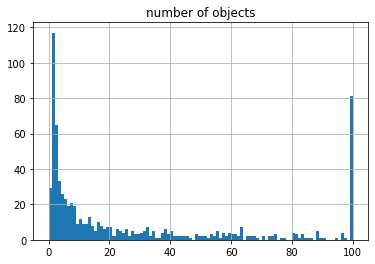

In [55]:
# By number of objects
max_people_limit = 100
number_of_people_stats = get_number_of_objects_stats(TRAIN_PROCESSED_DIR + '/labels')
number_of_people_stats[number_of_people_stats['number of objects'] > max_people_limit] = max_people_limit
number_of_people_stats[number_of_people_stats['number of objects'] <= max_people_limit].hist(column='number of objects',
                                                                                             bins=max_people_limit)

array([[<AxesSubplot:title={'center':'avg brightness'}>]], dtype=object)

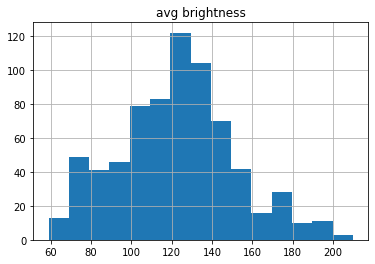

In [56]:
from data_processing.image_processing import get_brightness_stats

# By lightness
avg_lightness = get_brightness_stats(TRAIN_PROCESSED_DIR + '/images')
avg_lightness.hist(column='avg brightness', bins=15)

## 3.2 Example images

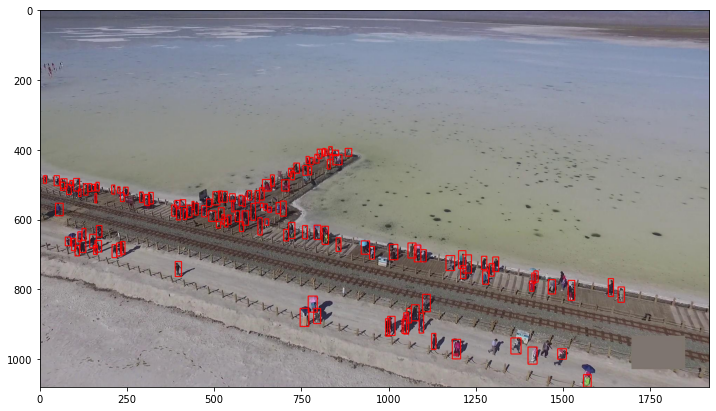

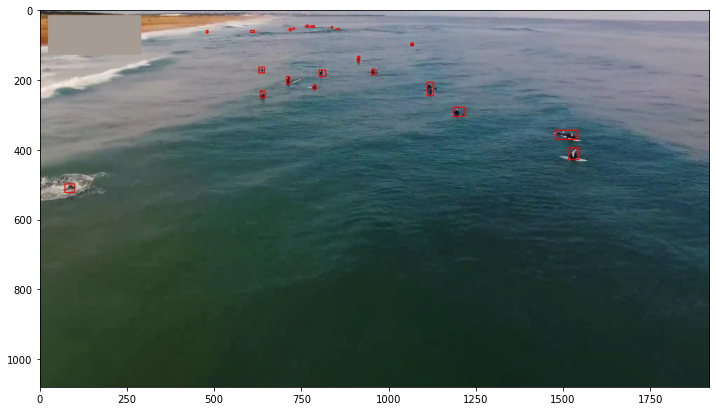

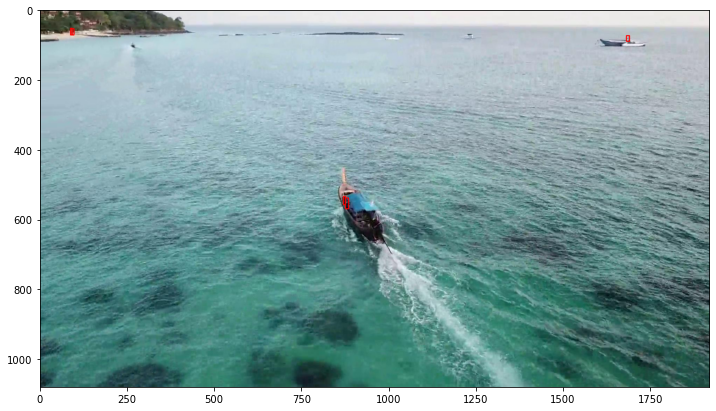

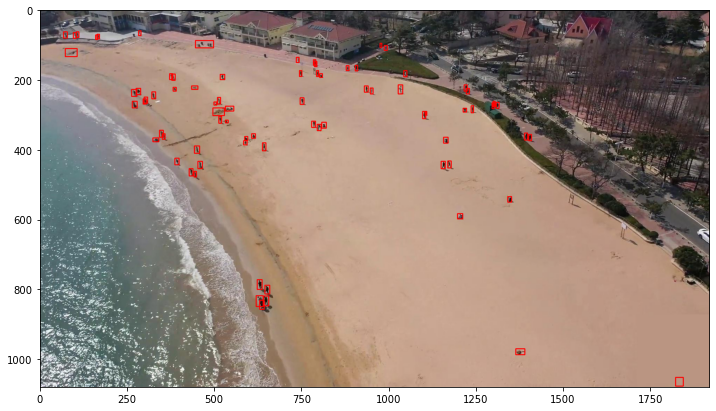

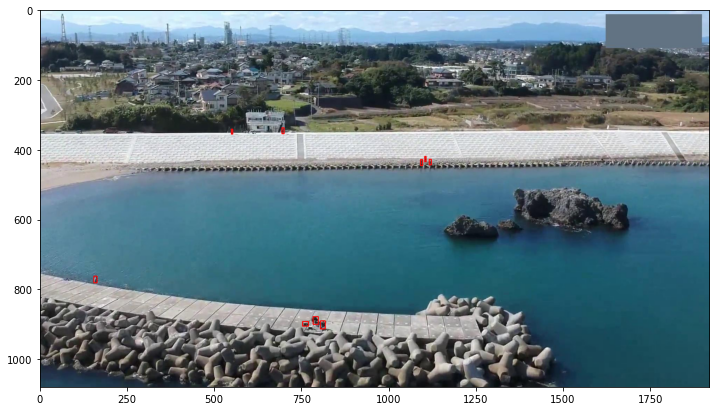

In [63]:
random.seed(23)
for filename in sample(os.listdir(f'{TRAIN_PROCESSED_DIR}/images'), 5):
    plot_xywhn_annotated_image_from_file(f'{TRAIN_PROCESSED_DIR}/images/{filename.split(".")[0]}.jpg',
                                         f'{TRAIN_PROCESSED_DIR}/labels/{filename.split(".")[0]}.txt')
